## Time Series Stationary Measures

* I'm going to try different metrics to measure whether a time series is stationary, because there are different types of stationary, different metrics measure different types of stationary, therefore when you are using multiple stationary measures, you may get opposite results.
* 3 types of stationary:
  * <b>Strict Stationary</b>: A strict stationary series satisfies the mathematical definition of a stationary process. The mean, variance and covariance are not the function of time.
  * <b>Trend Stationary</b>: A series that has no unit root but exhibits a trend is referred to as a trend stationary series. Once the trend is removed, the resulting series will be strict stationary. The KPSS test classifies a series as stationary on the absence of unit root. This means that the series can be strict stationary or trend stationary.
  * <b>Difference Stationary</b>: A time series that can be made strict stationary through differencing is difference stationary. ADF test is also known as a difference stationarity test.


* Similar work I did before: https://github.com/hanhanwu/Hanhan_Data_Science_Practice/blob/master/sequencial_analysis/python_ARIMA.ipynb
  * In this code, I tried different series preprocessing method, and used Rolling Mean & Standard Deviation, Dickey-Fuller Test as the metrics all the time.
  * So the code below is to add more stationary test options. Not just Rolling Mean & Standard Deviation, Augmented Dickey-Fuller Test (ADF), but also KPSS.
  
  
* Reference: https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/?utm_source=feedburner&utm_medium=email&utm_campaign=Feed%3A+AnalyticsVidhya+%28Analytics+Vidhya%29
* Download the data here: https://datamarket.com/data/set/22r0/sales-of-shampoo-over-a-three-year-period#!ds=22r0&display=line

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller

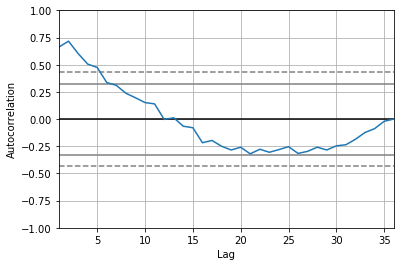

In [8]:
# This is the original time series
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

series = read_csv('shampoo_sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
autocorrelation_plot(series)
plt.show()

In [32]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12,center=False).mean()
    rolstd = timeseries.rolling(window=12,center=False).std()
    rolcov = timeseries.rolling(window=12,center=False).cov()

    # Plot rolling statistics:
    plt.figure(figsize=(9,7))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='green', label='Rolling Mean')
    std = plt.plot(rolstd, color='red', label = 'Rolling Std')
    cov = plt.plot(rolstd, color='purple', label = 'Rolling Cov')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Perform Augmented Dickey-Fuller test:
    print 'Results of Augmented Dickey-Fuller (ADF) Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput
    print
    
    # Perform KPSS
    print 'Results of KPSS Test:'
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print kpss_output

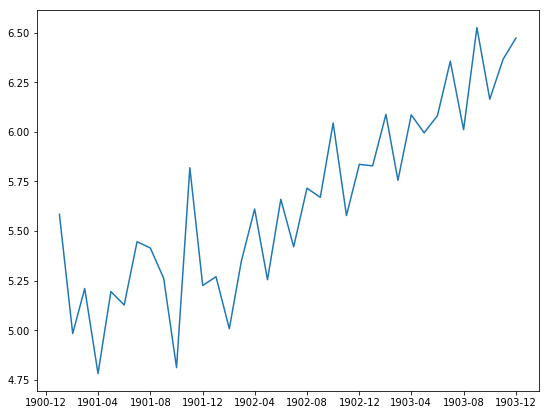

In [33]:
ts_log = np.log(series)
plt.figure(figsize=(9,7))
plt.plot(ts_log)
plt.show()

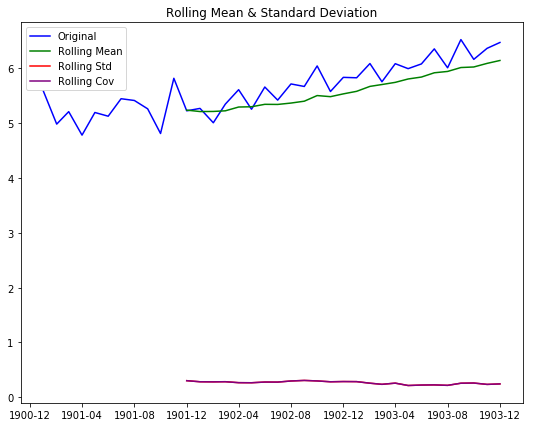

Results of Augmented Dickey-Fuller (ADF) Test:
Test Statistic                  1.798463
p-value                         0.998346
#Lags Used                     10.000000
Number of Observations Used    25.000000
Critical Value (5%)            -2.986489
Critical Value (1%)            -3.723863
Critical Value (10%)           -2.632800
dtype: float64

Results of KPSS Test:
Test Statistic            0.441996
p-value                   0.059053
Lags Used                10.000000
Critical Value (5%)       0.463000
Critical Value (1%)       0.739000
Critical Value (2.5%)     0.574000
Critical Value (10%)      0.347000
dtype: float64


In [34]:
test_stationarity(ts_log)

❣️Notes:
* It seems that in ADF, when test statistic is lower than critical value, it's stationary; but in KPSS when test statistic is higher than critical value, it's stationary.
* Also covariance and mean are always overlap here.
* Let's analysis above results:
  * The visualization is showing that, standard deviation maintains the same but mean is still changing with the time, so it's not strict stationary.
  * ADF test statstic is higher than all the critical value, so it's not differencing stationary, not strict stationary either.
  * KPSS test statistic is higher than 10% critical value, so it has 90% confidence that the series is trend stationary.
* Theoretically, if we try to remove the trend, it should become closer to strict stationary. Because it's trend stationary.

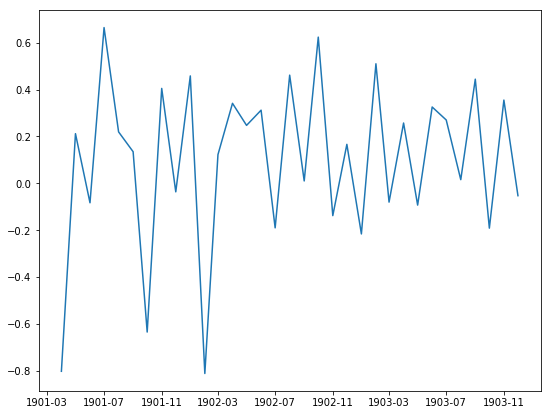

In [35]:
# I still want to try differencing.
ts_log_diff = ts_log - ts_log.shift(3)  # I tried 1, 7 steps too
plt.figure(figsize=(9,7))
plt.plot(ts_log_diff)
plt.show()

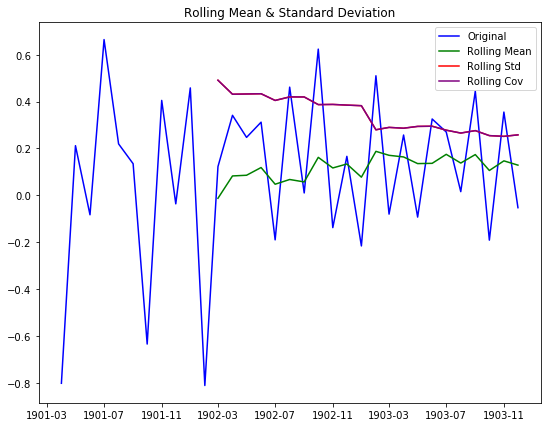

Results of Augmented Dickey-Fuller (ADF) Test:
Test Statistic                 -3.387790
p-value                         0.011382
#Lags Used                     10.000000
Number of Observations Used    22.000000
Critical Value (5%)            -3.005426
Critical Value (1%)            -3.769733
Critical Value (10%)           -2.642501
dtype: float64

Results of KPSS Test:
Test Statistic            0.358563
p-value                   0.095016
Lags Used                10.000000
Critical Value (5%)       0.463000
Critical Value (1%)       0.739000
Critical Value (2.5%)     0.574000
Critical Value (10%)      0.347000
dtype: float64


In [36]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

❣️Notes:
* I tried step=1,7 and 3 here. 1,7 all failed in ADF.
* Let's analysis above results with step=3:
  * The visualization is showing that, mean and standard devitation are showing less correlation to the time.
  * ADF test statstic is showing 95% confidence of differencing stationary.
  * KPSS test statistic is higher than 10% critical value, so it has 90% confidence that the series is (trend) stationary.
* This may indicate that, when a time series is not differencing stationary but trend stationary, it is still possible to make it stationary using differencing method, but shifting step can make a difference.